In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_1_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:13 - loss: 0.0117 - STD: 7.9709e-05 - MAE: 0.0913

 4/64 [>.............................] - ETA: 1s - loss: 0.0138 - STD: 2.3356e-04 - MAE: 0.0884  

 5/64 [=>............................] - ETA: 1s - loss: 0.0132 - STD: 3.2894e-04 - MAE: 0.0884

 6/64 [=>............................] - ETA: 2s - loss: 0.0132 - STD: 4.3314e-04 - MAE: 0.0900

 7/64 [==>...........................] - ETA: 2s - loss: 0.0128 - STD: 5.2404e-04 - MAE: 0.0894

 8/64 [==>...........................] - ETA: 2s - loss: 0.0125 - STD: 5.9621e-04 - MAE: 0.0879

 9/64 [===>..........................] - ETA: 2s - loss: 0.0123 - STD: 6.5091e-04 - MAE: 0.0866

10/64 [===>..........................] - ETA: 2s - loss: 0.0122 - STD: 7.0030e-04 - MAE: 0.0857

11/64 [====>.........................] - ETA: 2s - loss: 0.0121 - STD: 7.5311e-04 - MAE: 0.0849

12/64 [====>.........................] - ETA: 2s - loss: 0.0120 - STD: 8.1408e-04 - MAE: 0.0842

13/64 [=====>........................] - ETA: 2s - loss: 0.0118 - STD: 8.8406e-04 - MAE: 0.0836

14/64 [=====>........................] - ETA: 2s - loss: 0.0117 - STD: 9.6216e-04 - MAE: 0.0835

15/64 [======>.......................] - ETA: 2s - loss: 0.0116 - STD: 0.0010 - MAE: 0.0835    

16/64 [======>.......................] - ETA: 2s - loss: 0.0116 - STD: 0.0011 - MAE: 0.0836

17/64 [======>.......................] - ETA: 2s - loss: 0.0115 - STD: 0.0012 - MAE: 0.0836

18/64 [=======>......................] - ETA: 2s - loss: 0.0114 - STD: 0.0013 - MAE: 0.0833

19/64 [=======>......................] - ETA: 2s - loss: 0.0113 - STD: 0.0013 - MAE: 0.0828

20/64 [========>.....................] - ETA: 2s - loss: 0.0112 - STD: 0.0014 - MAE: 0.0824

21/64 [========>.....................] - ETA: 2s - loss: 0.0112 - STD: 0.0015 - MAE: 0.0821

22/64 [=========>....................] - ETA: 2s - loss: 0.0111 - STD: 0.0015 - MAE: 0.0818

23/64 [=========>....................] - ETA: 2s - loss: 0.0111 - STD: 0.0016 - MAE: 0.0815

24/64 [==========>...................] - ETA: 2s - loss: 0.0110 - STD: 0.0017 - MAE: 0.0813

25/64 [==========>...................] - ETA: 2s - loss: 0.0109 - STD: 0.0018 - MAE: 0.0812

26/64 [===========>..................] - ETA: 2s - loss: 0.0109 - STD: 0.0019 - MAE: 0.0811

27/64 [===========>..................] - ETA: 2s - loss: 0.0109 - STD: 0.0020 - MAE: 0.0811

28/64 [============>.................] - ETA: 1s - loss: 0.0108 - STD: 0.0021 - MAE: 0.0811

29/64 [============>.................] - ETA: 1s - loss: 0.0108 - STD: 0.0022 - MAE: 0.0810

30/64 [=============>................] - ETA: 1s - loss: 0.0107 - STD: 0.0023 - MAE: 0.0808

31/64 [=============>................] - ETA: 1s - loss: 0.0107 - STD: 0.0024 - MAE: 0.0806

32/64 [==============>...............] - ETA: 1s - loss: 0.0107 - STD: 0.0025 - MAE: 0.0804

33/64 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 0.0026 - MAE: 0.0803

34/64 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 0.0027 - MAE: 0.0801

35/64 [===============>..............] - ETA: 1s - loss: 0.0106 - STD: 0.0029 - MAE: 0.0800

36/64 [===============>..............] - ETA: 1s - loss: 0.0105 - STD: 0.0030 - MAE: 0.0799

37/64 [================>.............] - ETA: 1s - loss: 0.0105 - STD: 0.0032 - MAE: 0.0799

41/64 [==================>...........] - ETA: 1s - loss: 0.0104 - STD: 0.0041 - MAE: 0.0795

42/64 [==================>...........] - ETA: 1s - loss: 0.0104 - STD: 0.0043 - MAE: 0.0794

43/64 [===================>..........] - ETA: 1s - loss: 0.0103 - STD: 0.0046 - MAE: 0.0792

44/64 [===================>..........] - ETA: 1s - loss: 0.0103 - STD: 0.0048 - MAE: 0.0791

45/64 [====================>.........] - ETA: 1s - loss: 0.0102 - STD: 0.0052 - MAE: 0.0790

46/64 [====================>.........] - ETA: 1s - loss: 0.0102 - STD: 0.0055 - MAE: 0.0789

47/64 [=====================>........] - ETA: 1s - loss: 0.0102 - STD: 0.0059 - MAE: 0.0788

48/64 [=====================>........] - ETA: 0s - loss: 0.0101 - STD: 0.0063 - MAE: 0.0787

49/64 [=====================>........] - ETA: 0s - loss: 0.0101 - STD: 0.0067 - MAE: 0.0785

50/64 [======================>.......] - ETA: 0s - loss: 0.0101 - STD: 0.0071 - MAE: 0.0784

51/64 [======================>.......] - ETA: 0s - loss: 0.0100 - STD: 0.0075 - MAE: 0.0783

52/64 [=======================>......] - ETA: 0s - loss: 0.0100 - STD: 0.0080 - MAE: 0.0781

53/64 [=======================>......] - ETA: 0s - loss: 0.0100 - STD: 0.0084 - MAE: 0.0780

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 0.0089 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 0.0095 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 0.0100 - MAE: 0.0777

57/64 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 0.0105 - MAE: 0.0775

58/64 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0110 - MAE: 0.0774

59/64 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0115 - MAE: 0.0773

60/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 0.0120 - MAE: 0.0772

61/64 [===========================>..] - ETA: 0s - loss: 0.0097 - STD: 0.0125 - MAE: 0.0771

62/64 [============================>.] - ETA: 0s - loss: 0.0097 - STD: 0.0130 - MAE: 0.0770

63/64 [============================>.] - ETA: 0s - loss: 0.0097 - STD: 0.0134 - MAE: 0.0769

64/64 [==============================] - ETA: 0s - loss: 0.0097 - STD: 0.0139 - MAE: 0.0768

64/64 [==============================] - 6s 71ms/step - loss: 0.0097 - STD: 0.0139 - MAE: 0.0768 - val_loss: 0.0076 - val_STD: 0.0288 - val_MAE: 0.0677


Epoch 2/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0079 - STD: 0.0407 - MAE: 0.0686

 2/64 [..............................] - ETA: 4s - loss: 0.0079 - STD: 0.0402 - MAE: 0.0690

 3/64 [>.............................] - ETA: 3s - loss: 0.0079 - STD: 0.0400 - MAE: 0.0690

 4/64 [>.............................] - ETA: 3s - loss: 0.0079 - STD: 0.0398 - MAE: 0.0690

 5/64 [=>............................] - ETA: 3s - loss: 0.0079 - STD: 0.0394 - MAE: 0.0692

 6/64 [=>............................] - ETA: 3s - loss: 0.0079 - STD: 0.0392 - MAE: 0.0691

 7/64 [==>...........................] - ETA: 3s - loss: 0.0079 - STD: 0.0389 - MAE: 0.0692

 8/64 [==>...........................] - ETA: 3s - loss: 0.0079 - STD: 0.0388 - MAE: 0.0691

 9/64 [===>..........................] - ETA: 3s - loss: 0.0079 - STD: 0.0387 - MAE: 0.0691

10/64 [===>..........................] - ETA: 3s - loss: 0.0079 - STD: 0.0387 - MAE: 0.0691

11/64 [====>.........................] - ETA: 3s - loss: 0.0079 - STD: 0.0387 - MAE: 0.0690

12/64 [====>.........................] - ETA: 3s - loss: 0.0079 - STD: 0.0388 - MAE: 0.0690

13/64 [=====>........................] - ETA: 3s - loss: 0.0079 - STD: 0.0389 - MAE: 0.0689

14/64 [=====>........................] - ETA: 2s - loss: 0.0079 - STD: 0.0391 - MAE: 0.0689

15/64 [======>.......................] - ETA: 2s - loss: 0.0078 - STD: 0.0393 - MAE: 0.0689

16/64 [======>.......................] - ETA: 2s - loss: 0.0079 - STD: 0.0396 - MAE: 0.0688

17/64 [======>.......................] - ETA: 2s - loss: 0.0079 - STD: 0.0398 - MAE: 0.0688

18/64 [=======>......................] - ETA: 2s - loss: 0.0078 - STD: 0.0401 - MAE: 0.0688

19/64 [=======>......................] - ETA: 2s - loss: 0.0078 - STD: 0.0404 - MAE: 0.0687

20/64 [========>.....................] - ETA: 2s - loss: 0.0078 - STD: 0.0407 - MAE: 0.0686

21/64 [========>.....................] - ETA: 2s - loss: 0.0078 - STD: 0.0409 - MAE: 0.0685

23/64 [=========>....................] - ETA: 2s - loss: 0.0078 - STD: 0.0414 - MAE: 0.0682

24/64 [==========>...................] - ETA: 2s - loss: 0.0078 - STD: 0.0416 - MAE: 0.0681

25/64 [==========>...................] - ETA: 2s - loss: 0.0077 - STD: 0.0417 - MAE: 0.0680

26/64 [===========>..................] - ETA: 2s - loss: 0.0077 - STD: 0.0419 - MAE: 0.0680

27/64 [===========>..................] - ETA: 2s - loss: 0.0077 - STD: 0.0420 - MAE: 0.0679

28/64 [============>.................] - ETA: 2s - loss: 0.0077 - STD: 0.0421 - MAE: 0.0678

29/64 [============>.................] - ETA: 1s - loss: 0.0077 - STD: 0.0422 - MAE: 0.0678

30/64 [=============>................] - ETA: 1s - loss: 0.0077 - STD: 0.0423 - MAE: 0.0677

31/64 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.0424 - MAE: 0.0676

32/64 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.0425 - MAE: 0.0675

33/64 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.0426 - MAE: 0.0674

34/64 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.0427 - MAE: 0.0673

35/64 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.0428 - MAE: 0.0672

36/64 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.0429 - MAE: 0.0671

37/64 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.0430 - MAE: 0.0670

38/64 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.0432 - MAE: 0.0668

39/64 [=================>............] - ETA: 1s - loss: 0.0075 - STD: 0.0433 - MAE: 0.0667

40/64 [=================>............] - ETA: 1s - loss: 0.0075 - STD: 0.0435 - MAE: 0.0666

41/64 [==================>...........] - ETA: 1s - loss: 0.0074 - STD: 0.0437 - MAE: 0.0664

42/64 [==================>...........] - ETA: 1s - loss: 0.0074 - STD: 0.0439 - MAE: 0.0662

43/64 [===================>..........] - ETA: 1s - loss: 0.0074 - STD: 0.0442 - MAE: 0.0661

44/64 [===================>..........] - ETA: 1s - loss: 0.0074 - STD: 0.0444 - MAE: 0.0660

45/64 [====================>.........] - ETA: 1s - loss: 0.0073 - STD: 0.0448 - MAE: 0.0660

46/64 [====================>.........] - ETA: 1s - loss: 0.0073 - STD: 0.0449 - MAE: 0.0659

47/64 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0452 - MAE: 0.0657

48/64 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0456 - MAE: 0.0657

49/64 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0457 - MAE: 0.0656

50/64 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.0460 - MAE: 0.0655

51/64 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.0464 - MAE: 0.0655

52/64 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0465 - MAE: 0.0654

53/64 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0467 - MAE: 0.0653

54/64 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0470 - MAE: 0.0653

55/64 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0472 - MAE: 0.0652

56/64 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0473 - MAE: 0.0651

57/64 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0475 - MAE: 0.0650

58/64 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0478 - MAE: 0.0650

59/64 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0479 - MAE: 0.0648

60/64 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.0480 - MAE: 0.0648

61/64 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0482 - MAE: 0.0647

62/64 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0484 - MAE: 0.0647

63/64 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0485 - MAE: 0.0646

64/64 [==============================] - ETA: 0s - loss: 0.0071 - STD: 0.0486 - MAE: 0.0645

64/64 [==============================] - 4s 61ms/step - loss: 0.0071 - STD: 0.0486 - MAE: 0.0645 - val_loss: 0.0056 - val_STD: 0.0487 - val_MAE: 0.0595


Epoch 3/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0607

 2/64 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0614

 3/64 [>.............................] - ETA: 3s - loss: 0.0061 - STD: 0.0589 - MAE: 0.0600

 4/64 [>.............................] - ETA: 3s - loss: 0.0062 - STD: 0.0575 - MAE: 0.0595

 5/64 [=>............................] - ETA: 3s - loss: 0.0062 - STD: 0.0582 - MAE: 0.0598

 6/64 [=>............................] - ETA: 3s - loss: 0.0062 - STD: 0.0590 - MAE: 0.0604

 7/64 [==>...........................] - ETA: 3s - loss: 0.0062 - STD: 0.0585 - MAE: 0.0601

 8/64 [==>...........................] - ETA: 3s - loss: 0.0062 - STD: 0.0579 - MAE: 0.0598

 9/64 [===>..........................] - ETA: 3s - loss: 0.0062 - STD: 0.0579 - MAE: 0.0596

10/64 [===>..........................] - ETA: 3s - loss: 0.0062 - STD: 0.0584 - MAE: 0.0599

11/64 [====>.........................] - ETA: 3s - loss: 0.0062 - STD: 0.0584 - MAE: 0.0597

12/64 [====>.........................] - ETA: 3s - loss: 0.0062 - STD: 0.0580 - MAE: 0.0595

13/64 [=====>........................] - ETA: 3s - loss: 0.0061 - STD: 0.0579 - MAE: 0.0594

14/64 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0582 - MAE: 0.0596

15/64 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0584 - MAE: 0.0595

16/64 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0582 - MAE: 0.0593

17/64 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0582 - MAE: 0.0592

18/64 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0584 - MAE: 0.0593

19/64 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0585 - MAE: 0.0593

20/64 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0584 - MAE: 0.0591

22/64 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0587 - MAE: 0.0593

23/64 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0588 - MAE: 0.0593

24/64 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0587 - MAE: 0.0592

25/64 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0587 - MAE: 0.0591

26/64 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0590 - MAE: 0.0591

27/64 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0590 - MAE: 0.0590

28/64 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0590 - MAE: 0.0589

29/64 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0591 - MAE: 0.0588

30/64 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0593 - MAE: 0.0588

31/64 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0594 - MAE: 0.0588

32/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0594 - MAE: 0.0587

33/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0595 - MAE: 0.0587

34/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0596 - MAE: 0.0587

35/64 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0597 - MAE: 0.0586

36/64 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0597 - MAE: 0.0586

37/64 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0598 - MAE: 0.0586

38/64 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0599 - MAE: 0.0586

39/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0599 - MAE: 0.0585

40/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0600 - MAE: 0.0584

41/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0601 - MAE: 0.0584

42/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0602 - MAE: 0.0583

43/64 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0602 - MAE: 0.0582

44/64 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0603 - MAE: 0.0582

45/64 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0605 - MAE: 0.0582

46/64 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0604 - MAE: 0.0581

47/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0605 - MAE: 0.0581

48/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0606 - MAE: 0.0581

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0606 - MAE: 0.0580

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0607 - MAE: 0.0580

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0608 - MAE: 0.0580

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0609 - MAE: 0.0580

53/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0609 - MAE: 0.0579

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0610 - MAE: 0.0579

55/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0610 - MAE: 0.0578

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0610 - MAE: 0.0578

57/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0611 - MAE: 0.0578

58/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0612 - MAE: 0.0577

59/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0612 - MAE: 0.0577

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0613 - MAE: 0.0577

61/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0613 - MAE: 0.0577

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0613 - MAE: 0.0576

63/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0614 - MAE: 0.0576

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0614 - MAE: 0.0576

64/64 [==============================] - 4s 62ms/step - loss: 0.0059 - STD: 0.0614 - MAE: 0.0576 - val_loss: 0.0051 - val_STD: 0.0532 - val_MAE: 0.0542


Epoch 4/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0546

 2/64 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0552

 3/64 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0548

 4/64 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0547

 5/64 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0643 - MAE: 0.0550

 6/64 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0548

 7/64 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0548

 8/64 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0647 - MAE: 0.0552

 9/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0645 - MAE: 0.0550

10/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0648 - MAE: 0.0550

11/64 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0648 - MAE: 0.0550

12/64 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0648 - MAE: 0.0549

13/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0650 - MAE: 0.0549

14/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0647 - MAE: 0.0549

15/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0650 - MAE: 0.0549

16/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0649 - MAE: 0.0549

17/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0549

19/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0652 - MAE: 0.0547

20/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0653 - MAE: 0.0547

21/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0653 - MAE: 0.0547

22/64 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0548

23/64 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0547

24/64 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0656 - MAE: 0.0548

25/64 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0547

26/64 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0656 - MAE: 0.0548

27/64 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0548

28/64 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0656 - MAE: 0.0548

29/64 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0547

30/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0656 - MAE: 0.0548

31/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0547

32/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0547

33/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0547

34/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0547

35/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0546

36/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0546

37/64 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0546

38/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0545

39/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0545

40/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0545

41/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0544

42/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0544

43/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0543

44/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0543

45/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0543

46/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0542

47/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0544

48/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0656 - MAE: 0.0546

49/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0657 - MAE: 0.0546

50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0547

51/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0548

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0656 - MAE: 0.0549

53/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0658 - MAE: 0.0550

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0552

55/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0551

56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0557

57/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0560

58/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0564

59/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0563

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0646 - MAE: 0.0571

61/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0643 - MAE: 0.0571

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0638 - MAE: 0.0573

63/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0633 - MAE: 0.0575

64/64 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0630 - MAE: 0.0575

64/64 [==============================] - 4s 59ms/step - loss: 0.0060 - STD: 0.0630 - MAE: 0.0575 - val_loss: 0.0081 - val_STD: 0.0482 - val_MAE: 0.0785


Epoch 5/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0086 - STD: 0.0568 - MAE: 0.0801

 2/64 [..............................] - ETA: 3s - loss: 0.0084 - STD: 0.0553 - MAE: 0.0790

 3/64 [>.............................] - ETA: 3s - loss: 0.0077 - STD: 0.0505 - MAE: 0.0723

 4/64 [>.............................] - ETA: 3s - loss: 0.0077 - STD: 0.0462 - MAE: 0.0698

 5/64 [=>............................] - ETA: 3s - loss: 0.0078 - STD: 0.0434 - MAE: 0.0685

 6/64 [=>............................] - ETA: 3s - loss: 0.0075 - STD: 0.0422 - MAE: 0.0669

 7/64 [==>...........................] - ETA: 3s - loss: 0.0074 - STD: 0.0424 - MAE: 0.0664

 8/64 [==>...........................] - ETA: 3s - loss: 0.0074 - STD: 0.0432 - MAE: 0.0673

 9/64 [===>..........................] - ETA: 3s - loss: 0.0073 - STD: 0.0437 - MAE: 0.0674

11/64 [====>.........................] - ETA: 2s - loss: 0.0072 - STD: 0.0432 - MAE: 0.0657

12/64 [====>.........................] - ETA: 2s - loss: 0.0072 - STD: 0.0427 - MAE: 0.0652

13/64 [=====>........................] - ETA: 2s - loss: 0.0071 - STD: 0.0426 - MAE: 0.0647

14/64 [=====>........................] - ETA: 2s - loss: 0.0070 - STD: 0.0430 - MAE: 0.0644

15/64 [======>.......................] - ETA: 2s - loss: 0.0070 - STD: 0.0437 - MAE: 0.0645

16/64 [======>.......................] - ETA: 2s - loss: 0.0069 - STD: 0.0443 - MAE: 0.0645

17/64 [======>.......................] - ETA: 2s - loss: 0.0069 - STD: 0.0446 - MAE: 0.0642

18/64 [=======>......................] - ETA: 2s - loss: 0.0068 - STD: 0.0448 - MAE: 0.0638

19/64 [=======>......................] - ETA: 2s - loss: 0.0068 - STD: 0.0449 - MAE: 0.0634

20/64 [========>.....................] - ETA: 2s - loss: 0.0067 - STD: 0.0452 - MAE: 0.0631

21/64 [========>.....................] - ETA: 2s - loss: 0.0067 - STD: 0.0457 - MAE: 0.0629

22/64 [=========>....................] - ETA: 2s - loss: 0.0066 - STD: 0.0464 - MAE: 0.0629

23/64 [=========>....................] - ETA: 2s - loss: 0.0066 - STD: 0.0469 - MAE: 0.0627

24/64 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.0473 - MAE: 0.0625

25/64 [==========>...................] - ETA: 2s - loss: 0.0065 - STD: 0.0475 - MAE: 0.0622

26/64 [===========>..................] - ETA: 2s - loss: 0.0065 - STD: 0.0479 - MAE: 0.0620

27/64 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.0483 - MAE: 0.0617

28/64 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.0488 - MAE: 0.0616

29/64 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.0493 - MAE: 0.0615

30/64 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0497 - MAE: 0.0612

31/64 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0499 - MAE: 0.0610

32/64 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0502 - MAE: 0.0608

33/64 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0506 - MAE: 0.0606

34/64 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0510 - MAE: 0.0605

35/64 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0514 - MAE: 0.0603

36/64 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0516 - MAE: 0.0601

37/64 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0519 - MAE: 0.0599

38/64 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0522 - MAE: 0.0597

39/64 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0525 - MAE: 0.0596

40/64 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0528 - MAE: 0.0595

41/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0531 - MAE: 0.0593

42/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0534 - MAE: 0.0592

43/64 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0536 - MAE: 0.0590

44/64 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0540 - MAE: 0.0589

45/64 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0543 - MAE: 0.0588

46/64 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0546 - MAE: 0.0587

47/64 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.0548 - MAE: 0.0585

48/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0551 - MAE: 0.0584

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0583

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0557 - MAE: 0.0582

51/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0560 - MAE: 0.0581

52/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0562 - MAE: 0.0580

53/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0565 - MAE: 0.0579

54/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0568 - MAE: 0.0578

55/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0570 - MAE: 0.0577

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0576

57/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0575

58/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0577 - MAE: 0.0575

59/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0579 - MAE: 0.0574

60/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0573

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0572

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0572

63/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0571

64/64 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0570

64/64 [==============================] - 4s 62ms/step - loss: 0.0057 - STD: 0.0588 - MAE: 0.0570 - val_loss: 0.0046 - val_STD: 0.0605 - val_MAE: 0.0517


Epoch 6/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0516

 2/64 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0522

 4/64 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0524

 5/64 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0523

 6/64 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0523

 7/64 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0523

 8/64 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0523

 9/64 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0523

10/64 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0522

11/64 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0523

12/64 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0523

13/64 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0522

14/64 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0521

15/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0521

16/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0521

17/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0521

18/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0520

19/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0521

20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0521

21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0521

22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0521

23/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0521

24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0521

25/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0521

26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0520

27/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0520

28/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0520

29/64 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0520

30/64 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0520

31/64 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0520

32/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0520

33/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0520

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0520

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0520

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0520

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0520

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0520

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0520

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0520

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0520

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0520

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0520

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0519

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0519

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0519

47/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0519

48/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0519

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0519

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0519

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0519

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0519

53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0519

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0519

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0518

56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0518

57/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0518

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0518

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0518

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0518

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0518

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0518

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0518

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0518

64/64 [==============================] - 4s 60ms/step - loss: 0.0048 - STD: 0.0698 - MAE: 0.0518 - val_loss: 0.0044 - val_STD: 0.0614 - val_MAE: 0.0499


Epoch 7/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0515

 2/64 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0517

 3/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0516

 4/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0513

 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0714 - MAE: 0.0515

 6/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0513

 7/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0512

 8/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0514

 9/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0513

10/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0513

11/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0512

12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0513

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0512

14/64 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0512

15/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0512

16/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0512

17/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0511

18/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0511

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0511

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0511

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0511

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0510

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0510

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0511

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0510

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0510

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0511

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0511

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0511

30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0511

31/64 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0510

32/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

33/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0510

35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0510

37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0510

39/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0511

40/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

41/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

42/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0510

43/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0511

44/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

47/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

48/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

49/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

50/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0510

52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0510

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0509

55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0509

56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0509

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0509

58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0509

59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0509

61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

64/64 [==============================] - 4s 62ms/step - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509 - val_loss: 0.0043 - val_STD: 0.0667 - val_MAE: 0.0505


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0741 - MAE: 0.0520

 2/64 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0510

 3/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0505

 4/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0506

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0507

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0506

 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0506

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0507

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0506

10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0506

11/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0505

12/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0505

13/64 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0505

14/64 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0728 - MAE: 0.0504

15/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0504

16/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0505

17/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0504

18/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0728 - MAE: 0.0504

19/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0728 - MAE: 0.0504

21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0728 - MAE: 0.0505

23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0505

24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0506

25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0506

26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0507

27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0506

28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0506

29/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0506

30/64 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0505

31/64 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0506

32/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0506

33/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0506

34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0506

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0506

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0507

37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0507

38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0508

39/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0508

40/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0507

41/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0508

42/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0508

43/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0509

44/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0508

45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0508

46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0508

47/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0508

48/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0508

49/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0508

50/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0508

52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0508

53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0507

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0507

55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0507

56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0507

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0507

58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0507

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0507

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0507

61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0507

62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0507

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0507

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0507

64/64 [==============================] - 4s 61ms/step - loss: 0.0047 - STD: 0.0716 - MAE: 0.0507 - val_loss: 0.0045 - val_STD: 0.0694 - val_MAE: 0.0528


Epoch 9/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0545

 2/64 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0711 - MAE: 0.0524

 3/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0720 - MAE: 0.0519

 4/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0512

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0508

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0509

 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0507

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0507

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506

11/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0508

12/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0508

13/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0510

14/64 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0508

15/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0507

16/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0508

17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0508

18/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0509

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0509

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0509

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0509

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0509

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0508

27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0507

28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0508

29/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0507

30/64 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0507

31/64 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0507

32/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506

33/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0505

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0505

38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0505

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0505

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0504

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0504

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0504

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0505

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0505

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0505

47/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

48/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0505

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0506

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0506

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0506

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0506

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0506

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0507

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0507

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0507

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0507

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0508

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0508

61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0508

62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0508

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

64/64 [==============================] - 4s 61ms/step - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509 - val_loss: 0.0063 - val_STD: 0.0751 - val_MAE: 0.0654


Epoch 10/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0070 - STD: 0.0857 - MAE: 0.0677

 2/64 [..............................] - ETA: 3s - loss: 0.0084 - STD: 0.0643 - MAE: 0.0697

 3/64 [>.............................] - ETA: 3s - loss: 0.0081 - STD: 0.0590 - MAE: 0.0667

 4/64 [>.............................] - ETA: 3s - loss: 0.0084 - STD: 0.0662 - MAE: 0.0705

 6/64 [=>............................] - ETA: 2s - loss: 0.0082 - STD: 0.0600 - MAE: 0.0663

 7/64 [==>...........................] - ETA: 2s - loss: 0.0076 - STD: 0.0607 - MAE: 0.0644

 8/64 [==>...........................] - ETA: 2s - loss: 0.0076 - STD: 0.0624 - MAE: 0.0655

 9/64 [===>..........................] - ETA: 2s - loss: 0.0074 - STD: 0.0607 - MAE: 0.0642

10/64 [===>..........................] - ETA: 2s - loss: 0.0074 - STD: 0.0587 - MAE: 0.0638

11/64 [====>.........................] - ETA: 2s - loss: 0.0072 - STD: 0.0579 - MAE: 0.0628

12/64 [====>.........................] - ETA: 2s - loss: 0.0072 - STD: 0.0588 - MAE: 0.0637

13/64 [=====>........................] - ETA: 2s - loss: 0.0070 - STD: 0.0587 - MAE: 0.0631

14/64 [=====>........................] - ETA: 2s - loss: 0.0069 - STD: 0.0575 - MAE: 0.0626

15/64 [======>.......................] - ETA: 2s - loss: 0.0069 - STD: 0.0566 - MAE: 0.0622

16/64 [======>.......................] - ETA: 2s - loss: 0.0068 - STD: 0.0564 - MAE: 0.0617

17/64 [======>.......................] - ETA: 2s - loss: 0.0067 - STD: 0.0567 - MAE: 0.0620

18/64 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0567 - MAE: 0.0617

19/64 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0562 - MAE: 0.0612

20/64 [========>.....................] - ETA: 2s - loss: 0.0065 - STD: 0.0558 - MAE: 0.0609

21/64 [========>.....................] - ETA: 2s - loss: 0.0065 - STD: 0.0558 - MAE: 0.0606

22/64 [=========>....................] - ETA: 2s - loss: 0.0064 - STD: 0.0562 - MAE: 0.0607

23/64 [=========>....................] - ETA: 2s - loss: 0.0064 - STD: 0.0565 - MAE: 0.0605

24/64 [==========>...................] - ETA: 2s - loss: 0.0063 - STD: 0.0564 - MAE: 0.0602

25/64 [==========>...................] - ETA: 2s - loss: 0.0063 - STD: 0.0562 - MAE: 0.0599

26/64 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0564 - MAE: 0.0596

27/64 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0568 - MAE: 0.0596

28/64 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.0571 - MAE: 0.0594

29/64 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0571 - MAE: 0.0591

30/64 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0572 - MAE: 0.0588

31/64 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0574 - MAE: 0.0586

32/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0578 - MAE: 0.0585

33/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0581 - MAE: 0.0583

34/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0582 - MAE: 0.0581

35/64 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0584 - MAE: 0.0579

36/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0587 - MAE: 0.0577

37/64 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0591 - MAE: 0.0575

38/64 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0593 - MAE: 0.0574

39/64 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0594 - MAE: 0.0572

40/64 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0597 - MAE: 0.0570

41/64 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0600 - MAE: 0.0569

42/64 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0602 - MAE: 0.0568

43/64 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0604 - MAE: 0.0566

44/64 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0607 - MAE: 0.0565

45/64 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0610 - MAE: 0.0563

46/64 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0612 - MAE: 0.0562

47/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0561

48/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0559

49/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0620 - MAE: 0.0558

50/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0557

51/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0623 - MAE: 0.0555

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0626 - MAE: 0.0555

53/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0629 - MAE: 0.0554

54/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0630 - MAE: 0.0553

55/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0552

56/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0551

57/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0550

58/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0549

59/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0548

60/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0548

61/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0547

62/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0546

63/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0545

64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0646 - MAE: 0.0544

64/64 [==============================] - 4s 60ms/step - loss: 0.0053 - STD: 0.0646 - MAE: 0.0544 - val_loss: 0.0041 - val_STD: 0.0649 - val_MAE: 0.0489


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

 2/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0493

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0494

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

14/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

15/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0496

31/64 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

32/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

33/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0496

34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0496

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0496

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0496

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0496

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0496

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0496

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0496

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0496

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0496

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

47/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

48/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0495

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0495

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

64/64 [==============================] - 4s 59ms/step - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495 - val_loss: 0.0041 - val_STD: 0.0671 - val_MAE: 0.0486


Epoch 12/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

 2/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0494

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0493

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0491

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0492

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0491

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0491

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0492

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0492

12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0492

13/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0493

14/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0492

15/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0492

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0493

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0492

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0492

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0493

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0492

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0492

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0493

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0494

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0494

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0494

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0494

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0494

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0494

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

30/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495

31/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0495

32/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0495

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

47/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

48/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

64/64 [==============================] - 4s 61ms/step - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494 - val_loss: 0.0041 - val_STD: 0.0686 - val_MAE: 0.0490


Epoch 13/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0492

 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0487

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0492

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0489

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0489

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0490

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0489

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0488

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0490

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0490

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0490

12/64 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0492

13/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

14/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0492

15/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0493

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0493

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0493

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0493

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0493

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0494

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0494

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0494

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0495

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0495

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0495

30/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

31/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

32/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

47/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

48/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

64/64 [==============================] - 4s 60ms/step - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495 - val_loss: 0.0041 - val_STD: 0.0684 - val_MAE: 0.0495


Epoch 14/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0502

 2/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0497

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0498

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0501

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0503

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0502

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0503

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0503

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0502

10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0504

11/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

12/64 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0503

13/64 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0506

14/64 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0507

15/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0505

16/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0724 - MAE: 0.0517

17/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0527

18/64 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0695 - MAE: 0.0534

19/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0705 - MAE: 0.0544

20/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0701 - MAE: 0.0541

21/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0692 - MAE: 0.0541

22/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0689 - MAE: 0.0540

23/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0693 - MAE: 0.0544

24/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0687 - MAE: 0.0543

25/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0679 - MAE: 0.0543

26/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0677 - MAE: 0.0542

27/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0679 - MAE: 0.0545

28/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0544

29/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0544

30/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0543

31/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0545

32/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0544

33/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0663 - MAE: 0.0543

34/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0542

35/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0543

36/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0543

37/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0542

38/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0541

39/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0540

40/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0540

41/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0539

42/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0538

43/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0537

44/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0537

45/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0537

46/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0536

47/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0534

48/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0534

49/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0533

50/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0533

51/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0532

52/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0666 - MAE: 0.0531

53/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0666 - MAE: 0.0530

54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0667 - MAE: 0.0530

55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0529

56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0528

57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0671 - MAE: 0.0528

58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0672 - MAE: 0.0527

59/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0526

61/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0525

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0525

63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0524

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0524

64/64 [==============================] - 4s 60ms/step - loss: 0.0049 - STD: 0.0679 - MAE: 0.0524 - val_loss: 0.0040 - val_STD: 0.0672 - val_MAE: 0.0480


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0488

 2/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0765 - MAE: 0.0498

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0758 - MAE: 0.0495

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0492

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0492

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0491

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0490

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0490

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0490

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0489

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0489

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0489

13/64 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0489

14/64 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0489

15/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0489

16/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0489

17/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0489

18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0489

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0489

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0489

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0489

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0488

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0488

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0488

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0488

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

30/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

31/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

32/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

33/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0486

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0486

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0486

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0486

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0486

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0486

47/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0486

48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0486

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485

64/64 [==============================] - 4s 60ms/step - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485 - val_loss: 0.0041 - val_STD: 0.0646 - val_MAE: 0.0473


Epoch 16/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0487

 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0483

 3/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0486

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0486

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0485

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0484

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0485

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0483

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0483

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0483

13/64 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0483

14/64 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0484

16/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0483

17/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0484

18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0484

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0485

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0485

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0484

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0485

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0485

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0484

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0485

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0484

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0484

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0484

29/64 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0484

30/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0484

31/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0484

32/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0484

33/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0484

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0484

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0484

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

64/64 [==============================] - 4s 60ms/step - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483 - val_loss: 0.0040 - val_STD: 0.0649 - val_MAE: 0.0469


Epoch 17/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0478

 2/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0480

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0479

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0479

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0480

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0480

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0479

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0479

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0479

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0481

13/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0481

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0482

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0485

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0485

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0485

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0485

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0485

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0485

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

29/64 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0485

31/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485

32/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

33/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0486

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0486

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

47/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485

48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0485

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0485

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0485

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0485

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0485

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0485

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0485

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0485

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0485

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0485

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0485

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0485

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

64/64 [==============================] - 4s 61ms/step - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484 - val_loss: 0.0039 - val_STD: 0.0705 - val_MAE: 0.0479


Epoch 18/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0786 - MAE: 0.0487

 2/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0778 - MAE: 0.0485

 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0484

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0484

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0482

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0483

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0482

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0482

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0483

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0482

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0483

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0482

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0482

14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0483

15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0482

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0482

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0482

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0482

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0482

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0482

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0482

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0482

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0482

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0482

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0481

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0482

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0482

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0483

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0483

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0483

31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0483

32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0483

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0484

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0484

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0483

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0482

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0482

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0482

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0481

64/64 [==============================] - 4s 61ms/step - loss: 0.0042 - STD: 0.0752 - MAE: 0.0481 - val_loss: 0.0038 - val_STD: 0.0661 - val_MAE: 0.0465


Epoch 19/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0477

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0484

 3/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0491

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0491

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0493

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0490

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0488

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0489

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0487

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0487

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0486

13/64 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

14/64 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485

15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0483

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0483

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0482

29/64 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0484

31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0485

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0485

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0485

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0485

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0485

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

46/64 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0484

47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482

64/64 [==============================] - 4s 57ms/step - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482 - val_loss: 0.0041 - val_STD: 0.0731 - val_MAE: 0.0497


Epoch 20/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0810 - MAE: 0.0495

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0483

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0481

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0485

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0489

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0487

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0486

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0486

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0484

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482

15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0481

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0481

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0480

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0480

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0481

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0482

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0481

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0481

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0481

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0481

48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0481

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0480

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0480

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0480

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

64/64 [==============================] - 4s 61ms/step - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479 - val_loss: 0.0040 - val_STD: 0.0724 - val_MAE: 0.0487


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0489

 2/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481

 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0774 - MAE: 0.0486

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0481

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0481

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0479

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0477

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0478

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0478

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0479

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0478

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0479

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0478

14/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0479

15/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0478

16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0477

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0478

18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0478

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0478

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0478

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0477

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0477

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0476

31/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0476

32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0479

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0479

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0479

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0479

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0480

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0481

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0481

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0481

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0482

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483

47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0486

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0489

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0488

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0494

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0498

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0503

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0503

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0733 - MAE: 0.0513

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0726 - MAE: 0.0517

59/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0717 - MAE: 0.0524

60/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0708 - MAE: 0.0530

61/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0701 - MAE: 0.0532

62/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0696 - MAE: 0.0534

63/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0693 - MAE: 0.0541

64/64 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0689 - MAE: 0.0545

64/64 [==============================] - 4s 61ms/step - loss: 0.0055 - STD: 0.0689 - MAE: 0.0545 - val_loss: 0.0061 - val_STD: 0.0255 - val_MAE: 0.0621


Epoch 22/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0064 - STD: 0.0297 - MAE: 0.0628

 2/64 [..............................] - ETA: 3s - loss: 0.0070 - STD: 0.0257 - MAE: 0.0630

 3/64 [>.............................] - ETA: 3s - loss: 0.0077 - STD: 0.0232 - MAE: 0.0646

 4/64 [>.............................] - ETA: 3s - loss: 0.0081 - STD: 0.0218 - MAE: 0.0657

 5/64 [=>............................] - ETA: 3s - loss: 0.0083 - STD: 0.0211 - MAE: 0.0661

 6/64 [=>............................] - ETA: 3s - loss: 0.0081 - STD: 0.0212 - MAE: 0.0659

 7/64 [==>...........................] - ETA: 3s - loss: 0.0080 - STD: 0.0218 - MAE: 0.0663

 8/64 [==>...........................] - ETA: 3s - loss: 0.0079 - STD: 0.0228 - MAE: 0.0672

 9/64 [===>..........................] - ETA: 3s - loss: 0.0080 - STD: 0.0239 - MAE: 0.0685

10/64 [===>..........................] - ETA: 3s - loss: 0.0080 - STD: 0.0248 - MAE: 0.0692

11/64 [====>.........................] - ETA: 3s - loss: 0.0079 - STD: 0.0256 - MAE: 0.0693

12/64 [====>.........................] - ETA: 3s - loss: 0.0078 - STD: 0.0261 - MAE: 0.0690

13/64 [=====>........................] - ETA: 2s - loss: 0.0078 - STD: 0.0264 - MAE: 0.0686

14/64 [=====>........................] - ETA: 2s - loss: 0.0077 - STD: 0.0267 - MAE: 0.0682

15/64 [======>.......................] - ETA: 2s - loss: 0.0077 - STD: 0.0272 - MAE: 0.0678

16/64 [======>.......................] - ETA: 2s - loss: 0.0076 - STD: 0.0280 - MAE: 0.0674

17/64 [======>.......................] - ETA: 2s - loss: 0.0075 - STD: 0.0290 - MAE: 0.0671

18/64 [=======>......................] - ETA: 2s - loss: 0.0075 - STD: 0.0304 - MAE: 0.0669

19/64 [=======>......................] - ETA: 2s - loss: 0.0074 - STD: 0.0320 - MAE: 0.0669

20/64 [========>.....................] - ETA: 2s - loss: 0.0074 - STD: 0.0333 - MAE: 0.0668

21/64 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.0344 - MAE: 0.0666

22/64 [=========>....................] - ETA: 2s - loss: 0.0073 - STD: 0.0352 - MAE: 0.0662

23/64 [=========>....................] - ETA: 2s - loss: 0.0072 - STD: 0.0357 - MAE: 0.0658

24/64 [==========>...................] - ETA: 2s - loss: 0.0072 - STD: 0.0363 - MAE: 0.0655

25/64 [==========>...................] - ETA: 2s - loss: 0.0071 - STD: 0.0370 - MAE: 0.0652

26/64 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.0377 - MAE: 0.0649

27/64 [===========>..................] - ETA: 2s - loss: 0.0070 - STD: 0.0386 - MAE: 0.0647

28/64 [============>.................] - ETA: 2s - loss: 0.0069 - STD: 0.0394 - MAE: 0.0645

29/64 [============>.................] - ETA: 2s - loss: 0.0069 - STD: 0.0400 - MAE: 0.0643

30/64 [=============>................] - ETA: 1s - loss: 0.0068 - STD: 0.0404 - MAE: 0.0639

31/64 [=============>................] - ETA: 1s - loss: 0.0068 - STD: 0.0407 - MAE: 0.0636

32/64 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0410 - MAE: 0.0633

33/64 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0414 - MAE: 0.0630

34/64 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0420 - MAE: 0.0628

35/64 [===============>..............] - ETA: 1s - loss: 0.0066 - STD: 0.0425 - MAE: 0.0626

36/64 [===============>..............] - ETA: 1s - loss: 0.0065 - STD: 0.0429 - MAE: 0.0623

37/64 [================>.............] - ETA: 1s - loss: 0.0065 - STD: 0.0433 - MAE: 0.0620

38/64 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0437 - MAE: 0.0617

39/64 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0442 - MAE: 0.0615

40/64 [=================>............] - ETA: 1s - loss: 0.0063 - STD: 0.0447 - MAE: 0.0613

41/64 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0453 - MAE: 0.0611

42/64 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0458 - MAE: 0.0608

43/64 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.0462 - MAE: 0.0606

44/64 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.0467 - MAE: 0.0603

45/64 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.0473 - MAE: 0.0601

46/64 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.0479 - MAE: 0.0599

47/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0485 - MAE: 0.0597

48/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0489 - MAE: 0.0594

49/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0495 - MAE: 0.0592

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0501 - MAE: 0.0590

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0506 - MAE: 0.0588

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0511 - MAE: 0.0587

53/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0515 - MAE: 0.0585

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0520 - MAE: 0.0583

55/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0525 - MAE: 0.0581

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0529 - MAE: 0.0580

58/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0537 - MAE: 0.0576

59/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0541 - MAE: 0.0575

60/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0544 - MAE: 0.0573

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0547 - MAE: 0.0572

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0550 - MAE: 0.0570

63/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0554 - MAE: 0.0569

64/64 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0557 - MAE: 0.0568

64/64 [==============================] - 4s 59ms/step - loss: 0.0056 - STD: 0.0557 - MAE: 0.0568 - val_loss: 0.0041 - val_STD: 0.0645 - val_MAE: 0.0476


Epoch 23/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0707 - MAE: 0.0481

 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0483

 3/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0487

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0483

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0483

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0483

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

12/64 [====>.........................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

13/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0479

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0478

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0478

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0478

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0478

47/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0478

48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

64/64 [==============================] - 4s 60ms/step - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476 - val_loss: 0.0038 - val_STD: 0.0688 - val_MAE: 0.0466


Epoch 24/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0468

 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

11/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

12/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

13/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

14/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0472

15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0472

16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0472

18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0473

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

29/64 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475

30/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

31/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

47/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0473

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

64/64 [==============================] - 4s 60ms/step - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474 - val_loss: 0.0038 - val_STD: 0.0657 - val_MAE: 0.0460


Epoch 25/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0725 - MAE: 0.0465

 3/64 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

 4/64 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0473

 5/64 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0471

 6/64 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0472

 7/64 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0472

 8/64 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0470

 9/64 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471

10/64 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

11/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0470

12/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

13/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

14/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0469

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0468

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0468

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0468

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0468

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0467

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0467

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0467

30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0467

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0467

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0467

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0467

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0467

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0467

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0467

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0467

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0466

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0466

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0467

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0467

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0467

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0467

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0467

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0467

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0466

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0466

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0467

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0467

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0467

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0467

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0467

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0467

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0467

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0467

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0467

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0468

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0468

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

64/64 [==============================] - 4s 61ms/step - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469 - val_loss: 0.0047 - val_STD: 0.0576 - val_MAE: 0.0494


Epoch 26/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0641 - MAE: 0.0501

 2/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0480

 3/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0751 - MAE: 0.0504

 4/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0715 - MAE: 0.0508

 5/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0500

 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0527

 8/64 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0695 - MAE: 0.0533

 9/64 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0547

10/64 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0710 - MAE: 0.0541

11/64 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0697 - MAE: 0.0539

12/64 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0700 - MAE: 0.0534

13/64 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0708 - MAE: 0.0536

14/64 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0532

15/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0692 - MAE: 0.0529

16/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0527

17/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0528

18/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0525

19/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0523

20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0521

21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0522

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0520

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0518

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0516

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0516

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0688 - MAE: 0.0515

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0686 - MAE: 0.0513

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0686 - MAE: 0.0512

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0512

30/64 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0690 - MAE: 0.0511

31/64 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0510

32/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0508

33/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0692 - MAE: 0.0508

34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0694 - MAE: 0.0507

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0694 - MAE: 0.0506

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0505

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0697 - MAE: 0.0504

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0699 - MAE: 0.0503

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0699 - MAE: 0.0502

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0700 - MAE: 0.0502

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0501

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0500

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0705 - MAE: 0.0499

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0707 - MAE: 0.0499

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0708 - MAE: 0.0498

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0498

47/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0710 - MAE: 0.0497

48/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0497

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0496

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0495

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0495

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0494

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0494

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0493

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0493

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0492

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0491

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0721 - MAE: 0.0491

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0722 - MAE: 0.0491

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0722 - MAE: 0.0490

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0723 - MAE: 0.0490

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0724 - MAE: 0.0489

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0489

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0489

64/64 [==============================] - 4s 62ms/step - loss: 0.0043 - STD: 0.0725 - MAE: 0.0489 - val_loss: 0.0037 - val_STD: 0.0703 - val_MAE: 0.0464


Epoch 27/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0465

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0462

 4/64 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0470

 5/64 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

 6/64 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

 7/64 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0470

 8/64 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0470

 9/64 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0469

10/64 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

11/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0468

12/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0468

13/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

14/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0467

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0468

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0467

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0467

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0467

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0467

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0466

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0466

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0466

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0466

29/64 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0465

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0465

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0465

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463

64/64 [==============================] - 4s 60ms/step - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463 - val_loss: 0.0037 - val_STD: 0.0712 - val_MAE: 0.0463


Epoch 28/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0794 - MAE: 0.0467

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0794 - MAE: 0.0466

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0463

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0464

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0465

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0464

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0464

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0463

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0464

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0463

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0464

14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0464

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0465

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0465

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0466

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0467

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0467

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0468

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

30/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0470

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0470

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0470

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0470

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0470

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0471

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0471

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0472

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0471

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

47/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0472

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0472

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

64/64 [==============================] - 4s 62ms/step - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469 - val_loss: 0.0037 - val_STD: 0.0662 - val_MAE: 0.0453


Epoch 29/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0453

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

13/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0461

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0461

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0460

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0460

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0459

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0460

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0460

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0460

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

64/64 [==============================] - 4s 60ms/step - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461 - val_loss: 0.0037 - val_STD: 0.0718 - val_MAE: 0.0463


Epoch 30/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0466

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0465

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0466

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0466

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0467

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0466

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0466

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464

13/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0465

14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

29/64 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0460

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0460

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0460

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0459

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0460

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0460

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0460

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0460

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0460

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0461

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0463

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0463

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0463

64/64 [==============================] - 4s 60ms/step - loss: 0.0039 - STD: 0.0772 - MAE: 0.0463 - val_loss: 0.0046 - val_STD: 0.0775 - val_MAE: 0.0536


Epoch 31/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0527

 3/64 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0709 - MAE: 0.0513

 4/64 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0551

 5/64 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0709 - MAE: 0.0566

 6/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0677 - MAE: 0.0572

 7/64 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0708 - MAE: 0.0583

 8/64 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0708 - MAE: 0.0569

 9/64 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0694 - MAE: 0.0562

10/64 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0693 - MAE: 0.0552

11/64 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0554

12/64 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0699 - MAE: 0.0547

13/64 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0691 - MAE: 0.0542

14/64 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0690 - MAE: 0.0538

15/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0694 - MAE: 0.0538

16/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0693 - MAE: 0.0534

17/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0531

18/64 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0528

19/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0528

20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0525

21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0523

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0520

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0519

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0518

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0516

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0513

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0512

28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0693 - MAE: 0.0511

29/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0693 - MAE: 0.0509

30/64 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0693 - MAE: 0.0507

31/64 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0506

32/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0505

33/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0698 - MAE: 0.0504

34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0698 - MAE: 0.0503

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0700 - MAE: 0.0502

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0501

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0499

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0498

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0497

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0708 - MAE: 0.0496

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0496

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0495

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0495

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0494

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0493

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0717 - MAE: 0.0492

47/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0492

48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0491

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0490

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0721 - MAE: 0.0490

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0722 - MAE: 0.0489

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0723 - MAE: 0.0488

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0724 - MAE: 0.0488

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0487

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0486

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0486

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0485

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0485

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0484

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0484

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0483

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0732 - MAE: 0.0483

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0732 - MAE: 0.0482

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0733 - MAE: 0.0482

64/64 [==============================] - 4s 61ms/step - loss: 0.0042 - STD: 0.0733 - MAE: 0.0482 - val_loss: 0.0036 - val_STD: 0.0697 - val_MAE: 0.0451


Epoch 32/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0447

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0454

 4/64 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

 5/64 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

 6/64 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

 7/64 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0453

 8/64 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0454

 9/64 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0454

10/64 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

11/64 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0455

12/64 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

13/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0455

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0455

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0454

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0454

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0454

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

29/64 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

64/64 [==============================] - 4s 60ms/step - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455 - val_loss: 0.0036 - val_STD: 0.0696 - val_MAE: 0.0451


Epoch 33/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0448

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0453

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

64/64 [==============================] - 4s 61ms/step - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453 - val_loss: 0.0037 - val_STD: 0.0737 - val_MAE: 0.0465


Epoch 34/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0036 - STD: 0.0812 - MAE: 0.0453

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0446

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0445

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0451

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0454

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0453

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0455

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

64/64 [==============================] - 4s 62ms/step - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454 - val_loss: 0.0037 - val_STD: 0.0733 - val_MAE: 0.0462


Epoch 35/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0454

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0452

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0454

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0453

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0454

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0454

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0453

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0454

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0454

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0455

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0456

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0457

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0458

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0458

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456

64/64 [==============================] - 4s 61ms/step - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456 - val_loss: 0.0036 - val_STD: 0.0678 - val_MAE: 0.0447


Epoch 36/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0451

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 4/64 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

 5/64 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

 6/64 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

 7/64 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

 8/64 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

 9/64 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

10/64 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

11/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

12/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0453

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0454

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0454

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0454

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

29/64 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0454

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0454

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

64/64 [==============================] - 4s 59ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453 - val_loss: 0.0036 - val_STD: 0.0685 - val_MAE: 0.0448


Epoch 37/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0447

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0447

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

11/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

12/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0451

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0451

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

64/64 [==============================] - 4s 59ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452 - val_loss: 0.0038 - val_STD: 0.0654 - val_MAE: 0.0451


Epoch 38/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0448

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0457

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0455

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0452

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0454

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0452

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0453

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0453

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0453

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0452

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0452

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0452

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0452

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0452

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0452

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

64/64 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450 - val_loss: 0.0037 - val_STD: 0.0744 - val_MAE: 0.0464


Epoch 39/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0808 - MAE: 0.0453

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0451

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0446

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0444

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0445

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0445

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0445

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0445

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0445

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0449

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0449

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0449

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0449

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

64/64 [==============================] - 4s 59ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451 - val_loss: 0.0037 - val_STD: 0.0736 - val_MAE: 0.0461


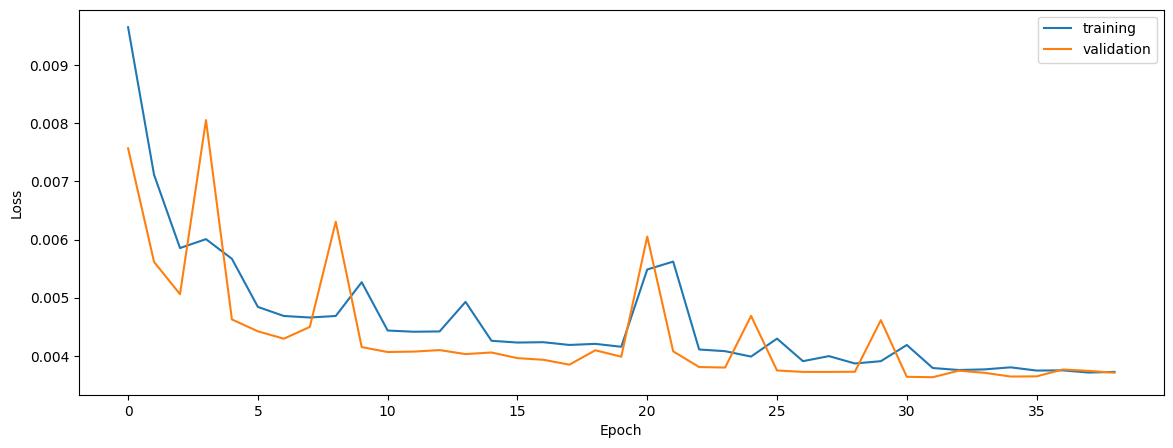

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7889956023938081
0.783754786782317
0.7789551955032316


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.7889956023938081
0.783754786782317
0.7789551955032316


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.792034495352538
0.7824111516731944
0.7861363990218249


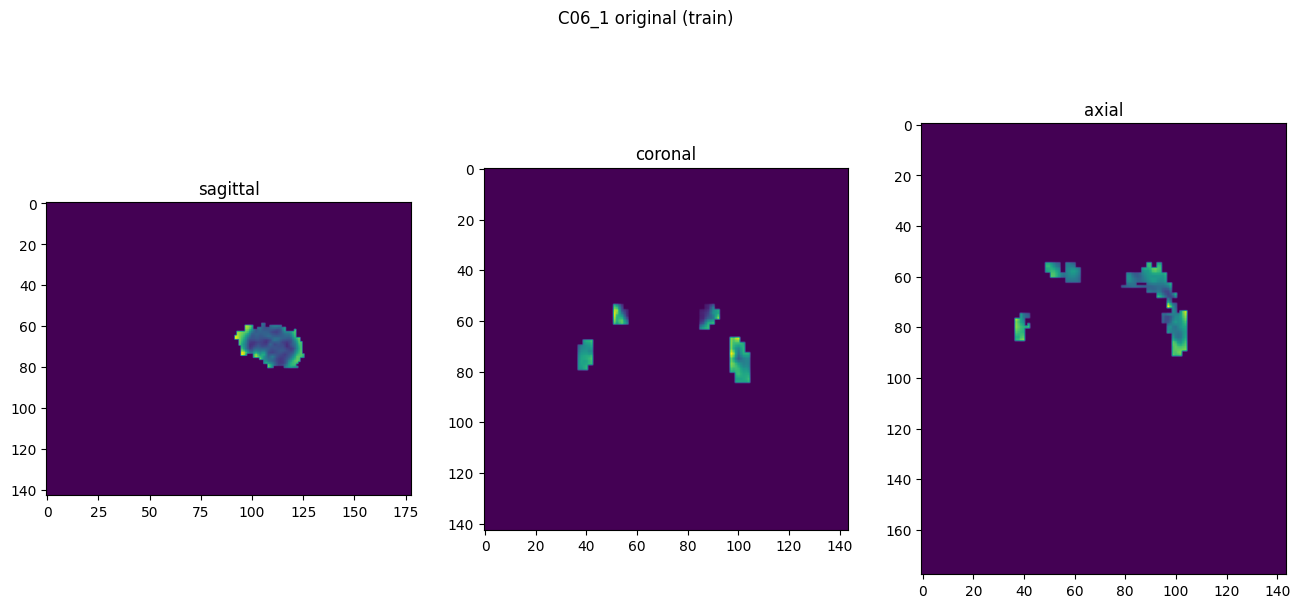

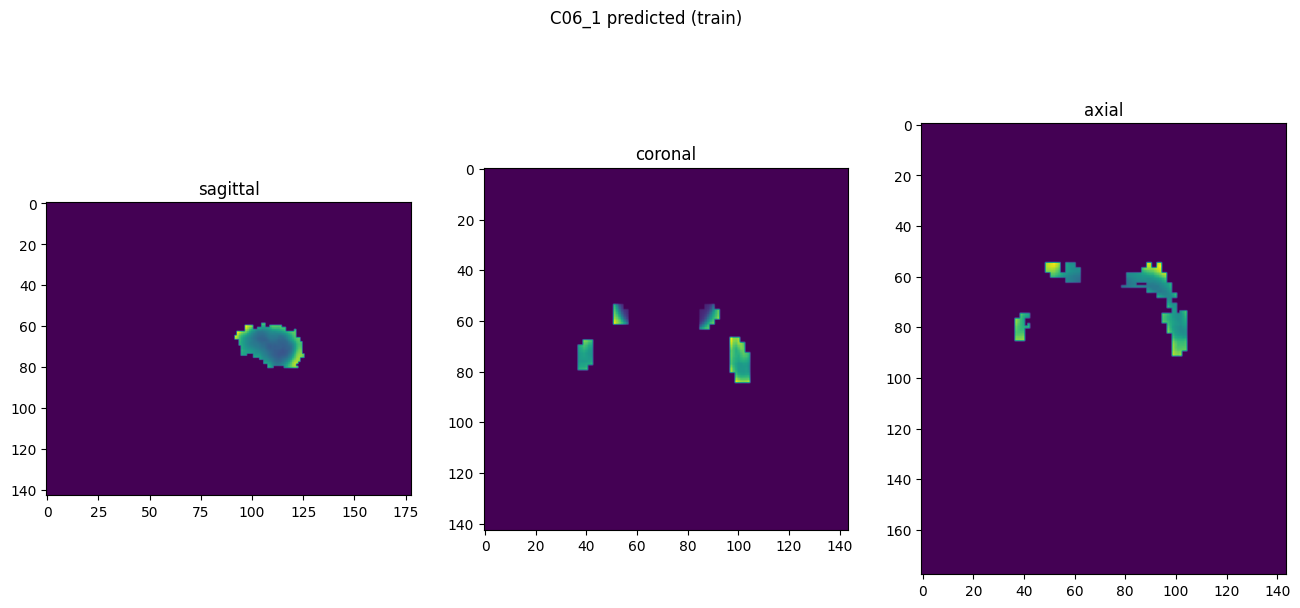

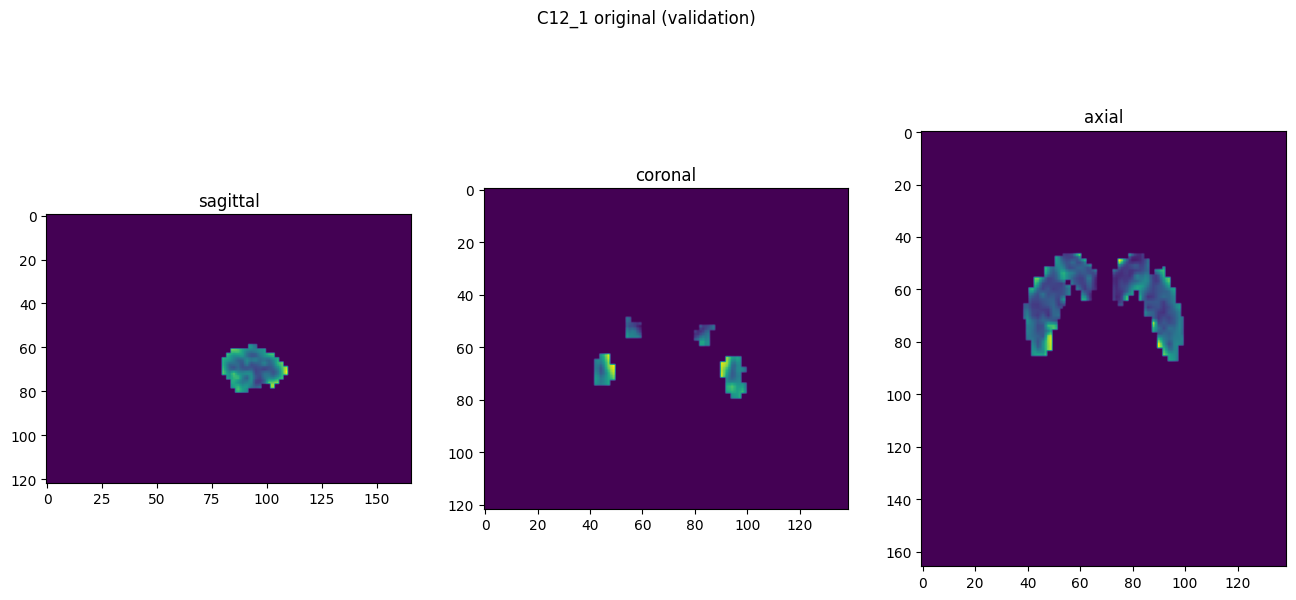

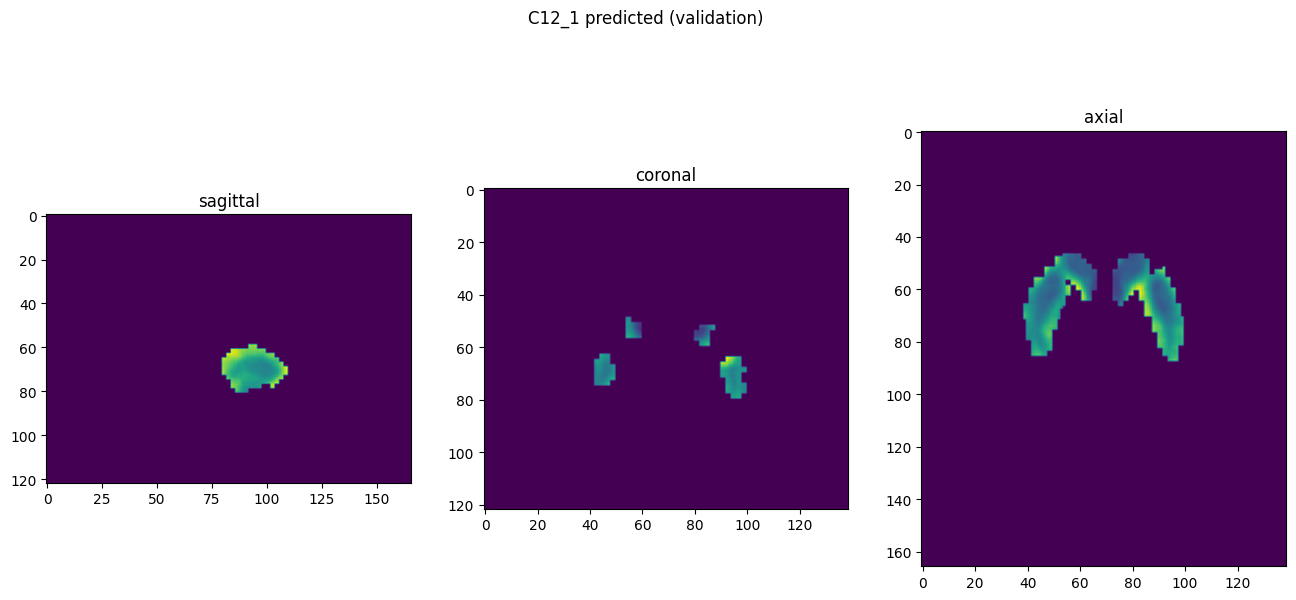

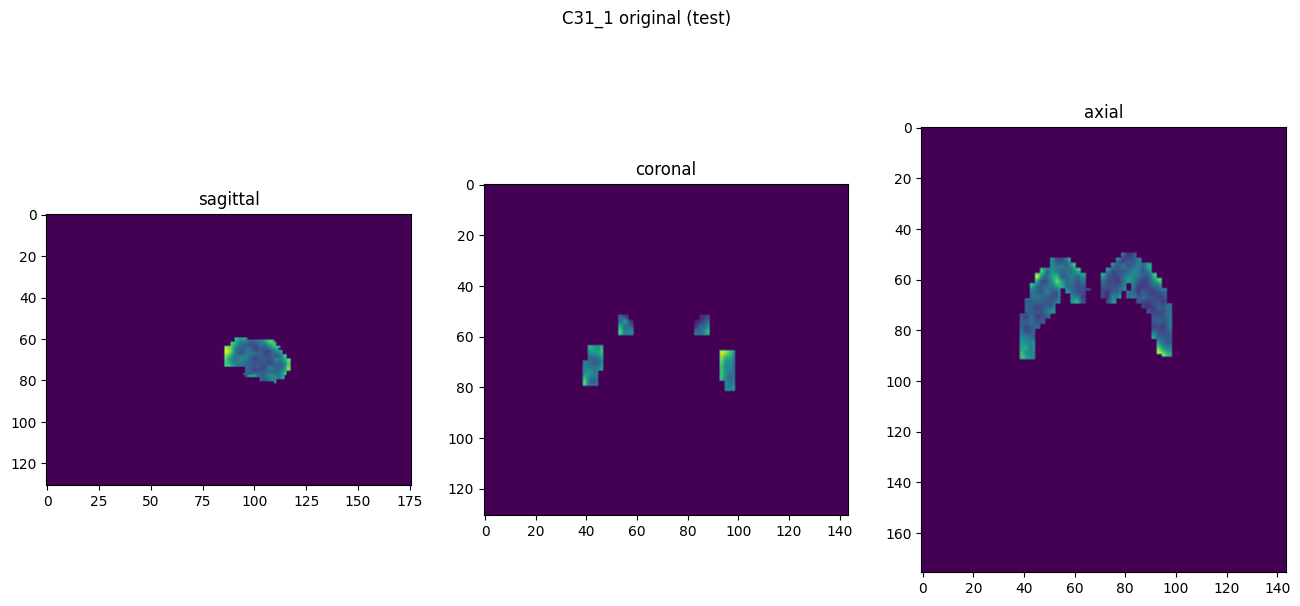

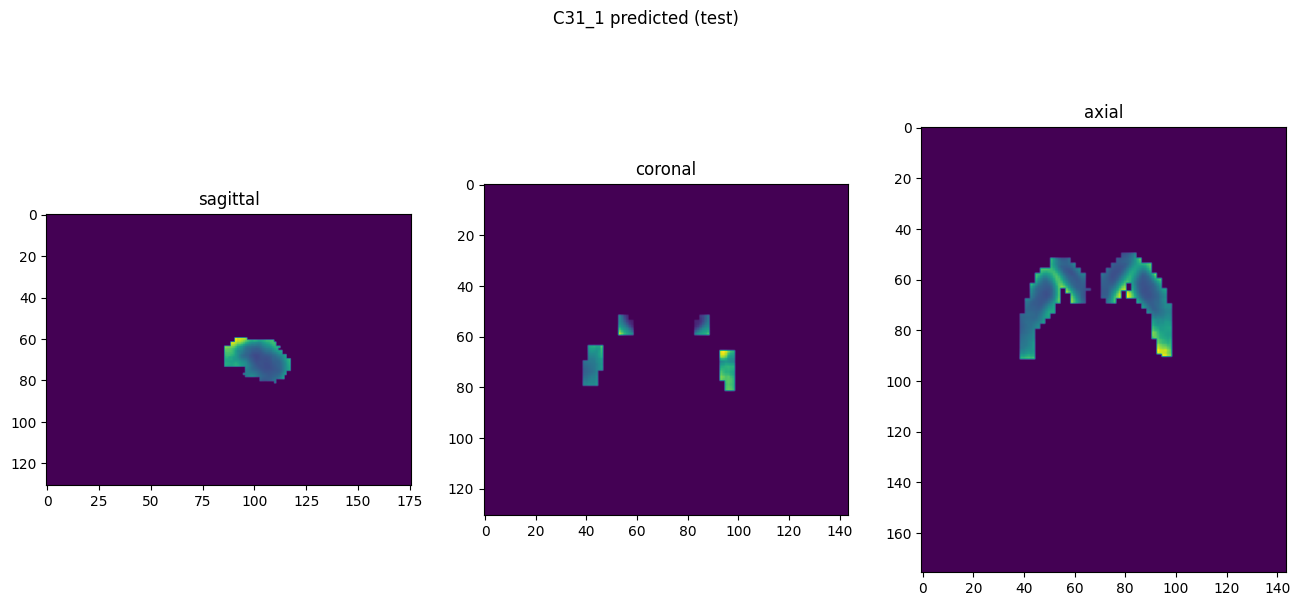

In [10]:
showResults(model, gen, threshold=None, background=False)